## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [23]:
import os
import numpy as np
import pandas as pd
import yaml


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FPVAE_T20 import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [110]:
ConfigName = 'TCMIL_ART_30_700'

yaml_path = './Config/Config.yml'
SavePath = './Results/'

ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
Capacity_Z = ConfigSet[ConfigName]['Capacity_Z']
Capacity_Fc = ConfigSet[ConfigName]['Capacity_Fc']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']

Patience = ConfigSet[ConfigName]['Patience']
WRec = ConfigSet[ConfigName]['WRec']
WFeat = ConfigSet[ConfigName]['WFeat']
WZ = ConfigSet[ConfigName]['WZ']
WFC = ConfigSet[ConfigName]['WFC']
WTC = ConfigSet[ConfigName]['WTC']
WMI = ConfigSet[ConfigName]['WMI']

### Other parameters
MnWRec = ConfigSet[ConfigName]['MnWRec']
MnWFeat = ConfigSet[ConfigName]['MnWFeat']
MnWZ = ConfigSet[ConfigName]['MnWZ']
MnWFC = ConfigSet[ConfigName]['MnWFC']
MnWTC = ConfigSet[ConfigName]['MnWTC']
MnWMI = ConfigSet[ConfigName]['MnWMI']

MxWRec = ConfigSet[ConfigName]['MxWRec']
MxWFeat = ConfigSet[ConfigName]['MxWFeat']
MxWZ = ConfigSet[ConfigName]['MxWZ']
MxWFC = ConfigSet[ConfigName]['MxWFC']
MxWTC = ConfigSet[ConfigName]['MxWTC']
MxWMI = ConfigSet[ConfigName]['MxWMI']

ModelName = ConfigName+'_'+SigType+'.hdf5'

### Model checkpoint
ModelSaveName = SavePath+ModelName


In [3]:
ModelName

'TCMIL_rawART_Z30_Comp700.hdf5'

### Data

In [111]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]

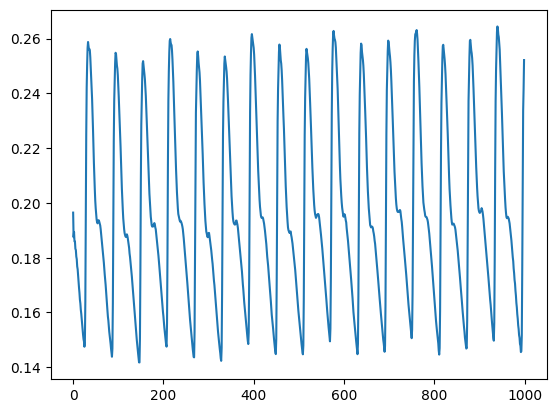

In [26]:
plt.plot(ValData[9])

### Post model

In [112]:
# Defining BioSigBandVAE
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=False, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

## Model core parts
EncInp =EncModel.input
InpZ = EncModel.output[2]
InpFCCommon = EncModel.output[1][:, :2]
InpFCEach = EncModel.output[1][:, 2:]

## Each output of each model
FeatExtOut = FeatExtModel(EncModel.output[:2])
FeatGenOut = FeatGenModel([InpFCCommon, InpFCEach, InpZ])
ReconExtOut = ReconModel(FeatExtOut)
ReconGenOut = ReconModel(FeatGenOut)

### Define the total model
SigBandRepModel = Model(EncInp, [FeatGenOut, ReconExtOut, ReconGenOut])

### Weight controller; Apply beta and capacity 
Beta_Z = Lossweight(name='Beta_Z', InitVal=0.05)(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc', InitVal=0.05)(FeatGenOut)
Beta_TC = Lossweight(name='Beta_TC', InitVal=0.05)(FeatGenOut)
Beta_MI = Lossweight(name='Beta_MI', InitVal=0.05)(FeatGenOut)
Beta_Rec_ext = Lossweight(name='Beta_Rec_ext', InitVal=500.)(FeatGenOut)
Beta_Rec_gen = Lossweight(name='Beta_Rec_gen', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)

### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()

ReconOut_ext = Beta_Rec_ext * MSE(ReconExtOut, EncInp)
SigBandRepModel.add_loss(ReconOut_ext)
SigBandRepModel.add_metric(ReconOut_ext, 'ReconOut_ext')

#ReconOut_gen = Beta_Rec_gen * MSE(ReconGenOut, EncInp)
#SigBandRepModel.add_loss(ReconOut_gen)
#SigBandRepModel.add_metric(ReconOut_gen, 'ReconOut_gen')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z) # sum_j KL(q(z_j)||p(z_j)) = sum_j (log q(z_j) - log p(z_j))
Z_Mu, Z_Log_Sigma, Zs = SigBandRepModel.get_layer('Z_Mu').output, SigBandRepModel.get_layer('Z_Log_Sigma').output, SigBandRepModel.get_layer('Zs').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Mu**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FC_Mu').output 
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)


### Total Correlation # KL(q(z)||prod_j q(z_j)) = log q(z) - sum_j log q(z_j)
LogProb_QZ = LogNormalDensity(Zs[:, None], Z_Mu[None], Z_Log_Sigma[None])
Log_QZ_Prod = tf.reduce_sum( tf.reduce_logsumexp(LogProb_QZ, axis=1, keepdims=False),   axis=1,  keepdims=False)
Log_QZ = tf.reduce_logsumexp(tf.reduce_sum(LogProb_QZ, axis=2, keepdims=False),   axis=1,   keepdims=False)
kl_Loss_TC = -tf.reduce_mean(Log_QZ - Log_QZ_Prod)
kl_Loss_TC = Beta_TC * kl_Loss_TC

### MI Loss ; I[z;x] = KL[q(z,x)||q(x)q(z)] = E_x[KL[q(z|x)||q(z)]] = KL(q(z|x)||q(z)) = log q(z|x) - log q(z)
Log_QZX = tf.reduce_sum(LogNormalDensity(Zs, Z_Mu, Z_Log_Sigma), axis=1)
kl_Loss_MI = -tf.reduce_mean((Log_QZX - Log_QZ))
kl_Loss_MI = Beta_MI * kl_Loss_MI



SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')


SigBandRepModel.add_loss(kl_Loss_TC )
SigBandRepModel.add_metric(kl_Loss_TC , 'kl_Loss_TC')

SigBandRepModel.add_loss(kl_Loss_MI )
SigBandRepModel.add_metric(kl_Loss_MI , 'kl_Loss_MI')
''''''

### Load weights
SigBandRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigBandRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Rec_ext','Beta_Rec_gen', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigBandRepModel.compile(optimizer='adam') 

In [91]:
SigBandRepModel.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_35 (TFOpLambda) (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional_90 (Bidirectional (None, 20, 50)       11550       tf.signal.frame_35[0][0]         
__________________________________________________________________________________________________
bidirectional_91 (Bidirectional (None, 20, 50)       11550       bidirectional_90[0][0]           
____________________________________________________________________________________________

### Reconstruction; MSE

In [38]:
RecPred = SigBandRepModel.predict(ValData,  batch_size=3500, verbose=1)[-1]

23/23 [==============================] - 14s 203ms/step


In [41]:
SigBandRepModel.evaluate(ValData,  batch_size=3500, verbose=1)

23/23 [==============================] - 4s 162ms/step - loss: 18.7876 - ReconOutGen: 0.0036 - FeatRecLoss: 5.6729e-04 - kl_Loss_Z: 0.4808 - kl_Loss_FC: 0.0589 - kl_Loss_TC: 18.2436


[18.78759765625,
 0.003648278769105673,
 0.000567288079764694,
 0.48082607984542847,
 0.05892202630639076,
 18.243633270263672]

In [ ]:
EvalMSE = tf.keras.losses.MeanSquaredError()
EvalMSE(ValData, RecPred)

### From extractor to reconstruction validation 
#### It ultimately evaluates the performance of the reconstructor

(100, 1000)


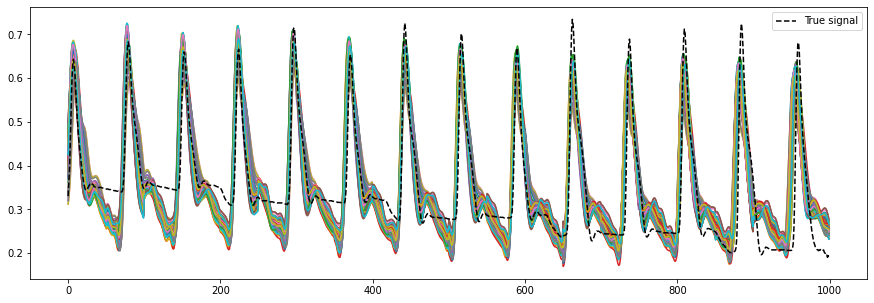

In [113]:
idx = 0

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtract (ValData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)

#### From extractor to reconstruction LL

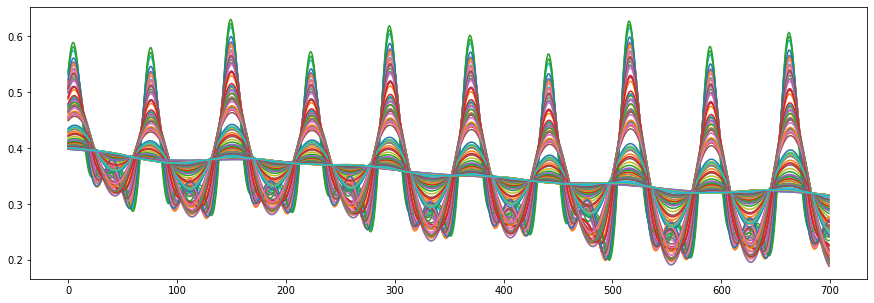

In [93]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(LL.numpy()[i])

#### From extractor to reconstruction HH

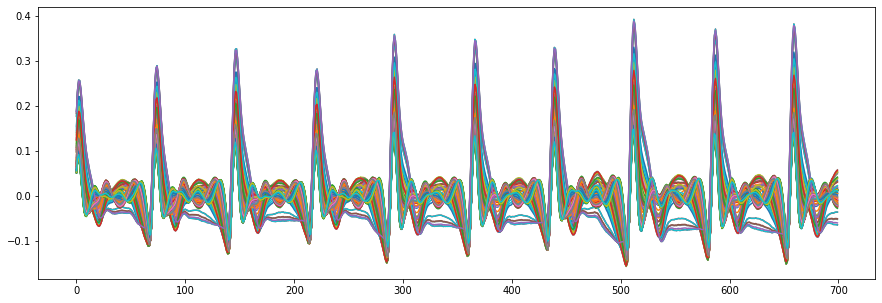

In [94]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(HH.numpy()[i])

### Permutation Local Correlation Monotonicity Index (PLCMI)

In [ ]:
PLCMI_Res = PLMI(FeatGenModel,  ReconModel, LatDim=LatDim, N_Gen=300, N_Interval=20,
                 MonoWinSize=300, MinZval = -10., MaxZval = 10., N_FreqSel =3,  
                 MinFreq=1, MaxFreq=51, Weight='Continuity', Type='L2')

In [6]:
PLCMI_Res = PLMI2(FeatGenModel,  ReconModel, LatDim=LatDim, N_Gen=300, N_Interval=20,
                 MonoWinSize=300, MinZval = -10., MaxZval = 10., N_FreqSel =3,  
                 MinFreq=1, MaxFreq=51, Weight='Continuity', Type='L2')

[0, -10.0, 323.4754, [20, 10, 9]]
[0, -8.95, 450.3438, [20, 10, 9]]
[0, -7.89, 469.6122, [20, 10, 9]]
[0, -6.84, 499.6387, [20, 10, 9]]
[0, -5.79, 502.6474, [20, 10, 9]]
[0, -4.74, 429.502, [20, 10, 9]]
[0, -3.68, 522.3473, [20, 9, 10]]
[0, -2.63, 916.584, [20, 9, 10]]
[0, -1.58, 884.0769, [20, 9, 10]]
[0, -0.53, 845.9676, [14, 13, 12]]
[0, 0.53, 606.3526, [12, 14, 13]]
[0, 1.58, 1188.2717, [14, 13, 12]]
[0, 2.63, 927.0695, [13, 25, 12]]
[0, 3.68, 828.771, [11, 13, 12]]
[0, 4.74, 615.9153, [13, 11, 12]]
[0, 5.79, 511.4152, [11, 13, 12]]
[0, 6.84, 629.8189, [14, 13, 12]]
[0, 7.89, 521.9394, [14, 12, 13]]
[0, 8.95, 449.5973, [14, 12, 13]]
[0, 10.0, 284.5263, [25, 12, 13]]
[1, -10.0, 1561.2788, [12, 27, 13]]
[1, -8.95, 758.9644, [14, 27, 13]]
[1, -7.89, 1103.3827, [28, 14, 13]]
[1, -6.84, 1126.2689, [28, 14, 13]]
[1, -5.79, 1138.7388, [28, 13, 14]]
[1, -4.74, 827.9333, [28, 13, 14]]
[1, -3.68, 888.4101, [12, 13, 14]]
[1, -2.63, 917.6094, [12, 14, 13]]
[1, -1.58, 1115.5129, [12, 13, 14]]
[

In [60]:
LPEI_Res = LPEI(FeatGenModel,  ReconModel, LatDim=LatDim, N_Gen=300, N_Interval=20,
                 MonoWinSize=300, MinZval = -10., MaxZval = 10., N_FreqSel =3,  
                 MinFreq=1, MaxFreq=51, Weight='RevHHI')

[0, -10.0, 2.7715746693671934, [9, 1, 0]]
[0, -8.95, 2.7276937380706126, [9, 1, 0]]
[0, -7.89, 2.727558127528737, [9, 1, 0]]
[0, -6.84, 2.6984442694659077, [10, 11, 0]]



KeyboardInterrupt



In [114]:
LPEI_Res = LPEI2(FeatGenModel,  ReconModel, LatDim=LatDim, N_Gen=300, N_Interval=20,
                 MonoWinSize=300, MinZval = -10., MaxZval = 10., N_FreqSel =3,  
                 MinFreq=1, MaxFreq=51, Weight='RevHHI')

[0, -10.0, 0.768730951262757, [22, 11, 10]]
[0, -8.95, 0.8078407028635255, [22, 11, 10]]
[0, -7.89, 0.8959048973338014, [22, 11, 10]]
[0, -6.84, 0.9002253302480616, [22, 11, 10]]
[0, -5.79, 0.9368081602104846, [22, 11, 10]]
[0, -4.74, 1.0480290873811007, [22, 10, 11]]
[0, -3.68, 0.8810244771455543, [22, 10, 11]]
[0, -2.63, 0.9096504875751497, [22, 10, 11]]
[0, -1.58, 0.8351624459171182, [22, 14, 15]]
[0, -0.53, 0.8746549156354627, [13, 15, 14]]
[0, 0.53, 0.8171895862284846, [13, 15, 14]]
[0, 1.58, 0.895610205464839, [18, 16, 17]]
[0, 2.63, 0.8301116705488596, [18, 16, 17]]
[0, 3.68, 0.8472306886622717, [7, 16, 8]]
[0, 4.74, 0.8583109496564622, [16, 7, 8]]
[0, 5.79, 0.8958421768462013, [7, 16, 8]]
[0, 6.84, 0.8797987187505759, [17, 16, 8]]
[0, 7.89, 0.8934730407469699, [16, 17, 8]]
[0, 8.95, 0.9042764784389731, [9, 17, 8]]
[0, 10.0, 0.9760719572987685, [9, 17, 8]]
[1, -10.0, 0.7483261798842417, [19, 21, 20]]
[1, -8.95, 0.7090171267864653, [19, 21, 20]]
[1, -7.89, 0.7549324959052081, [42

<ipython-input-118-70dd4bc732cd>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  plt.imshow(np.array(LPEI_Res)[:, -2].reshape(-1, 20) > 1.)


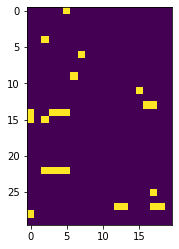

In [118]:
plt.imshow(np.array(LPEI_Res)[:, -2].reshape(-1, 20) > 1.)

### Qualitative evaluation of the amplitude relationship between the input frequency for signal generation (y-axis) and the frequency of the generated signal (x-axis).

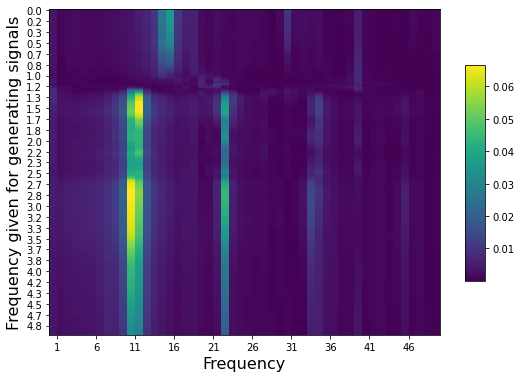

In [116]:
ZFix = {0:-5.79}
#ZFix = {2:1.32, 9:3.32}
#zVal[:,0] = -3
#Val[:,1] = 2.33
#zVal[:,2] = 0.4
#zVal[:,3] = -1.67
#zVal[:,4] = 0.33
#zVal[:,5] = 3
#zVal[:,6] = -1.67
#zVal[:,7] = 3
#zVal[:,8] = 3
#zVal[:,9] = -1

HeatMapFrequency(FeatGenModel,  ReconModel, LatDim, ZFix, N_Gen=300)

### Visualizing the reconstruction conditioned on a specific z-value when frequencies are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input frequencies on signal generation when a specific z-value is given.

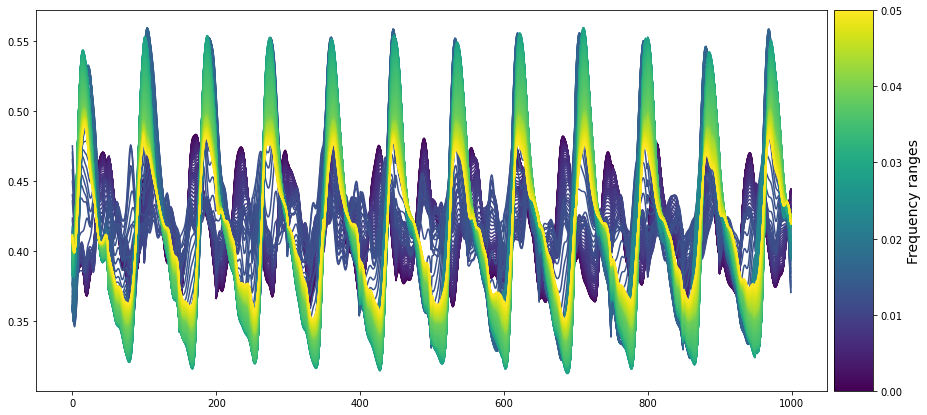

In [117]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

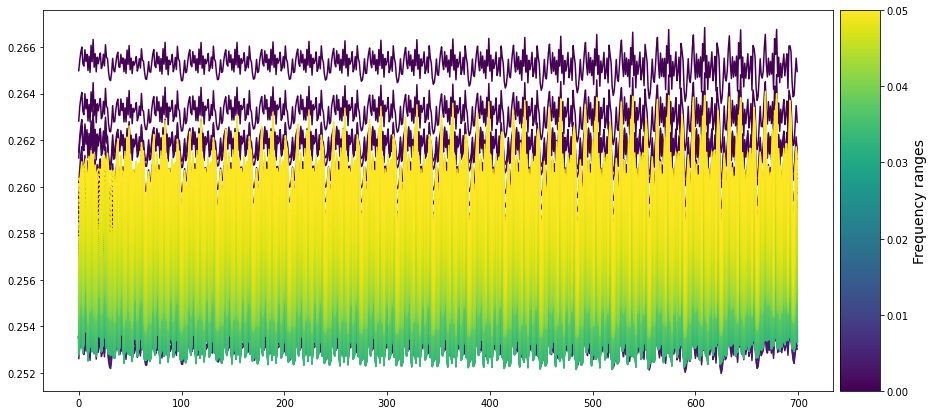

In [97]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='LL', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

### Visualizing the reconstruction conditioned on a specific frequency value when z-values are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input z-values on signal generation when a specific frequency is given.

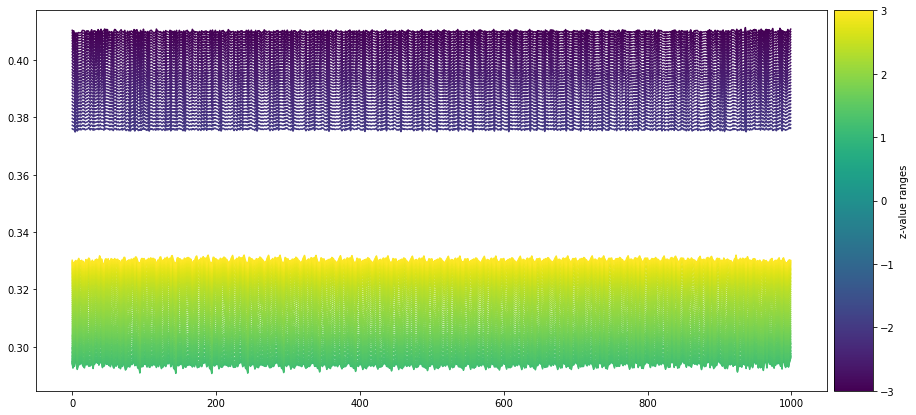

In [33]:
FcCommFix = {0:0.05, 1:0.05}
FcEachFix = {0:0.05, 1:0.05, 2:0.05, 3:0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFreq (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=200, MinZval = -3., MaxZval = 3., CutLower=-2., CutUpper = 1.)

### From generator to reconstruction validation

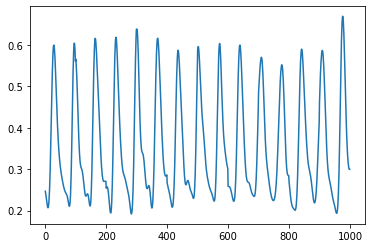

In [25]:
idx = 175
plt.plot(RecPred[idx])

### Visualizing amplitude by frequency given a specific ID

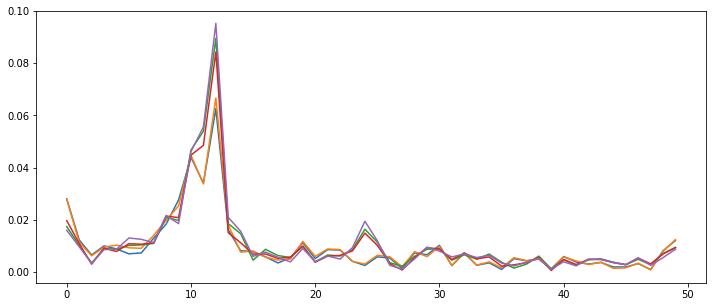

In [26]:
# GenSig_zVar
N_Gen= 300
SigGen5, Amplitude5 = GenSig_zVar(FeatGenModel, ReconModel, 0.05, N_Gen=N_Gen)
SigGen4, Amplitude4 = GenSig_zVar(FeatGenModel, ReconModel,  0.04, N_Gen=N_Gen)
SigGen3, Amplitude3 = GenSig_zVar(FeatGenModel, ReconModel,  0.03, N_Gen=N_Gen)
SigGen2, Amplitude2 = GenSig_zVar(FeatGenModel, ReconModel,  0.02, N_Gen=N_Gen)
SigGen1, Amplitude1 = GenSig_zVar(FeatGenModel, ReconModel,  0.01, N_Gen=N_Gen)

plt.figure(figsize=(12, 5))
idx = 20
plt.plot(Amplitude5[idx, 1:51])
plt.plot(Amplitude4[idx, 1:51])
plt.plot(Amplitude3[idx, 1:51])
plt.plot(Amplitude2[idx, 1:51])
plt.plot(Amplitude1[idx, 1:51])

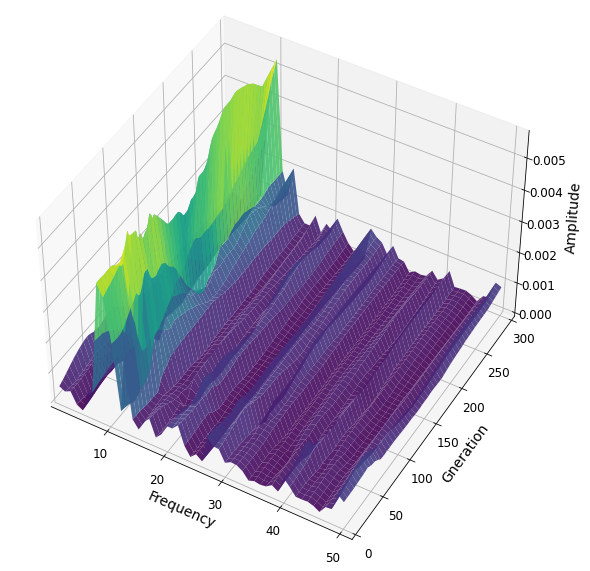

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_Gen = 300
MinFreq=1
MaxFreq=50


# GenSig_FcVar
zVal = np.tile(np.zeros(LatDim), (N_Gen,1))
SigGen_FcVar, Amplitude_FcVar = GenSig_FcVar(FeatGenModel,  ReconModel,zVal, N_Gen=N_Gen, zType='Fixed')

# Axes generation
FreqX = np.arange(0, N_Gen)
GenY = np.arange(MinFreq, MaxFreq+1)
FreqX, GenY = np.meshgrid(GenY, FreqX)

# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(FreqX, GenY, Amplitude_FcVar[:, MinFreq:MaxFreq+1], cmap='viridis', linewidth=1, antialiased=True, alpha = 0.9)

# Axis labels
ax.set_xlabel('Frequency', fontsize=14, labelpad=5.5)
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', labelsize=12)
ax.set_xlim(left=MinFreq, right=MaxFreq+1)

ax.set_ylabel('Gneration', fontsize=14, labelpad=6.5)
ax.set_yticks(ax.get_yticks())
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(bottom=0, top=N_Gen)

ax.set_zlabel('Amplitude', fontsize=14, labelpad=11.)
ax.set_zticks(ax.get_zticks())
ax.tick_params(axis='z', labelsize=12, pad=5)  
ax.set_zlim(bottom=0, top=Amplitude_FcVar[:, MinFreq:MaxFreq+1].max())

ax.view_init(azim=300, elev=45)
plt.show()

0.9805394539290764
0.8677809621412361
0.9026369761239742
0.9681947618707605


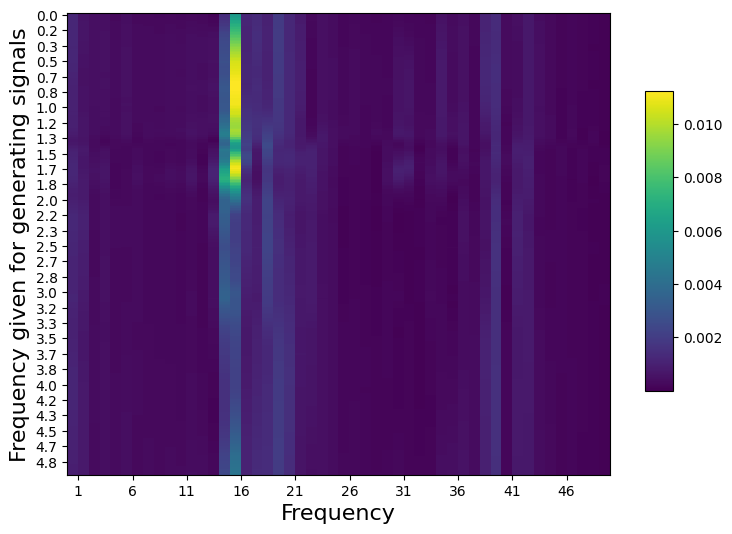

In [21]:
import EntropyHub as EH

ZFix = {3:-1}
idx = 14

LatDim = 20
MinFreq=1 
MaxFreq=51
N_Gen = 300

zVal = np.tile(np.zeros(LatDim), (N_Gen,1))
for KeyVal in ZFix.items():
    zVal[:,KeyVal[0]] = KeyVal[1]

SigGen_FcVar, Amplitude_FcVar = GenSig_FcVar(FeatGenModel,  ReconModel, zVal, N_Gen=N_Gen, zType='Fixed')
Heatmap = Amplitude_FcVar[:, MinFreq:MaxFreq]

fig, ax = plt.subplots(figsize=(7,6))
cax = fig.add_axes([0.95, 0.25, 0.04, 0.5])

im = ax.imshow(Heatmap,  cmap='viridis', aspect='auto',interpolation='nearest') 
ax.set(yticks=np.arange(1, N_Gen)[::10], yticklabels=np.round(np.linspace(1e-7, 0.05, N_Gen )[::10]*100, 1));
ax.set(xticks=np.arange(1, MaxFreq)[::5]-0.5, xticklabels=np.arange(1, MaxFreq)[::5]);
ax.set_xlabel('Frequency', fontsize=16)
ax.set_ylabel('Frequency given for generating signals', fontsize=16) 

fig.colorbar(im, cax=cax, orientation='vertical')
print(EH.PermEn(Heatmap[:, idx])[0][1])

MaxIDX = np.argsort(Heatmap, axis=1)[:, -N_FreqSel:]
for IDSeq in MaxIDX.T:
    print(np.exp(-EH.PermEn(IDSeq)[0][1]))